In [3]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook determines an e-distance for each perturbation relative to control cells to (relatively) quantify their magnitude ###

import h5py
import numpy as np
import pandas as pd
import nexusformat.nexus as nx
import tables
import scipy
import scanpy as sc
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as pl
%load_ext rpy2.ipython

# # Custom functions
# import sys
# sys.path.insert(1, '../src')
from scperturb import *

In [4]:
### things to vary to get better p-values and non-negative distances

## the control guide which things are assessed relative to (spend time picking good controls)
## assess # of control cells vs pertuabtion cells and vary the number of sampled cells in class imbalance
## look how big the radius of perturbation and control is in PC space and cutoff # of PCs used in dist calculation
## lower max variable features during to 500?


In [5]:
## Load in data ##
adata = sc.read('/home/ssobti/projects/mir_tud/110222_filtered_data/miR.concat.raw.adata_gex.guide_assigned.h5')

Only considering the two last: ['.guide_assigned', '.h5'].
Only considering the two last: ['.guide_assigned', '.h5'].


In [6]:
#meta data prior to filtering
meta = adata.obs
meta.head()

sample           barcode            guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  miR_1  AAACCCAAGGAGAGGC  hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  miR_1  AAACCCAAGGTAAACT    hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  miR_1  AAACCCACAACGATCT  hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  miR_1  AAACCCACACGATTCA        TuD_NC_18  5.859895   
miR_1:AAACCCACAGTCAACT-1  miR_1  AAACCCACAGTCAACT  hsa-miR-147b-5p  5.632808   

                                 pvalue     adj_pvalue  max_umi  n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0   78.0   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  108.0   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  113.0   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  114.0   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0   86.0   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   

                          log_m_umi  
miR_1:AAACCCAAGGAGAGGC-1  -0.706696  
miR_1:AAACCCAAGGTAAACT-1  -0.565367  
miR_1:AAACCCACAACGATCT-1  -0.545712  
miR_1:AAACCCACACGATTCA-1  -0.541886  
miR_1:AAACCCACAGTCAACT-1  -0.664292

In [7]:
count_df = meta.groupby(by = ['guide']).size().reset_index(name = 'cells')
idxs = count_df.loc[:,'guide'].str.startswith('TuD')
type = ['control' if x is True else 'perturbation' for x in idxs]
count_df['type'] = type
count_df

guide  cells          type
0           TuD_NC_01   1687       control
1           TuD_NC_02     50       control
2           TuD_NC_03     82       control
3           TuD_NC_04     72       control
4           TuD_NC_05     58       control
..                ...    ...           ...
392  hsa-miR-10399-5p     67  perturbation
393  hsa-miR-10401-3p     48  perturbation
394  hsa-miR-10523-5p    110  perturbation
395  hsa-miR-10526-3p     87  perturbation
396  hsa-miR-10527-5p    121  perturbation

[397 rows x 3 columns]

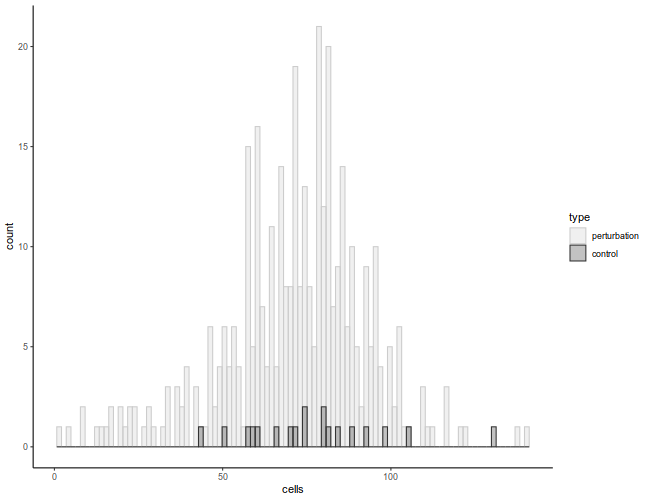

In [8]:
%%R -i count_df -w 650 -h 500
### data exploration of cells per perturbation with histogram

library(ggplot2)
count_df2 = count_df[!count_df$guide == 'TuD_NC_01',]
count_df2$type <- factor(count_df2$type, levels = c('perturbation', 'control'))

## without TuD_NC_01 which has 1687 cells
ggplot(count_df2, aes(x = cells, fill = type, color = type)) + 
geom_histogram(position = "identity", alpha = 0.3, bins = 100) + scale_color_grey(start = 0.8, end = 0.2) +
scale_fill_grey(start = 0.8, end = 0.2) + theme_classic()

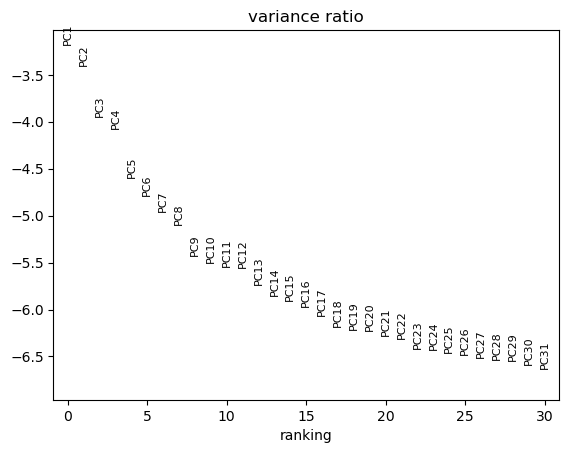

In [9]:
# basic qc and pp
adata.layers['counts'] = adata.X.copy()
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=50)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)


# high class imbalance
adata = equal_subsampling(adata, 'guide', N_min=50)
sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

# select HVGs
n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


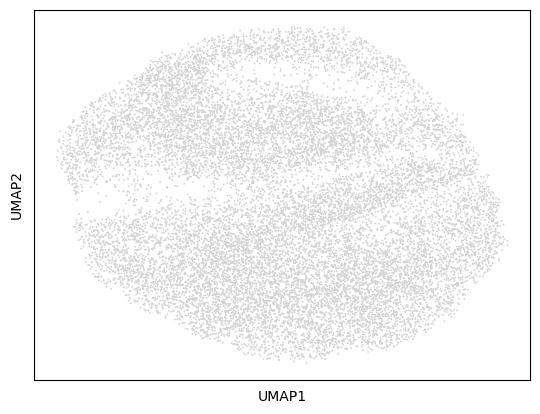

In [10]:
### figure out how many PCs needed
sc.pp.pca(adata, n_comps=10, use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata)

In [11]:
adata.uns['processed'] = True

In [12]:
#meta data post-filtering
meta = adata.obs
meta

sample           barcode           guide       lor  \
miR_1:ATTTACCGTCATGGCC-1  miR_1  ATTTACCGTCATGGCC       TuD_NC_01  3.597523   
miR_2:AGCGTATCAATGACCT-1  miR_2  AGCGTATCAATGACCT       TuD_NC_01  0.629471   
miR_2:GCCAGGTAGGAGTACC-1  miR_2  GCCAGGTAGGAGTACC       TuD_NC_01  4.196521   
miR_2:CCTCTAGTCCTAGAGT-1  miR_2  CCTCTAGTCCTAGAGT       TuD_NC_01  4.064724   
miR_3:GTCTCACAGCTCTGTA-1  miR_3  GTCTCACAGCTCTGTA       TuD_NC_01  3.976555   
...                         ...               ...             ...       ...   
miR_2:GGTAGAGTCTACGGGC-1  miR_2  GGTAGAGTCTACGGGC  hsa-miR-423-5p  2.902440   
miR_2:CTGTGAACACAGTCCG-1  miR_2  CTGTGAACACAGTCCG  hsa-miR-423-5p  1.770472   
miR_1:ATAGGCTAGTAAGGGA-1  miR_1  ATAGGCTAGTAAGGGA  hsa-miR-423-5p  4.361066   
miR_2:ATTCCATGTGTACAGG-1  miR_2  ATTCCATGTGTACAGG  hsa-miR-423-5p  1.113251   
miR_2:TGATTTCAGCGTCTCG-1  miR_2  TGATTTCAGCGTCTCG  hsa-miR-423-5p  5.381739   

                                 pvalue     adj_pvalue  max_umi  n_umi  \
miR_1:ATTTACCGTCATGGCC-1   1.730526e-45   1.746539e-38     40.0   65.0   
miR_2:AGCGTATCAATGACCT-1   2.036000e-07   1.000000e+00      8.0   34.0   
miR_2:GCCAGGTAGGAGTACC-1   9.101111e-57   9.472211e-50     48.0   78.0   
miR_2:CCTCTAGTCCTAGAGT-1   6.093434e-64   6.341895e-57     57.0  100.0   
miR_3:GTCTCACAGCTCTGTA-1   2.013763e-54   1.612518e-47     46.0   85.0   
...                                 ...            ...      ...    ...   
miR_2:GGTAGAGTCTACGGGC-1   3.718338e-29   3.869954e-22     10.0   14.0   
miR_2:CTGTGAACACAGTCCG-1   2.662270e-15   2.770824e-08      7.0   41.0   
miR_1:ATAGGCTAGTAAGGGA-1  7.813807e-187  7.886111e-180     76.0   95.0   
miR_2:ATTCCATGTGTACAGG-1  1.315885e-263  1.369540e-256    121.0  280.0   
miR_2:TGATTTCAGCGTCTCG-1  2.318224e-129  2.412750e-122     51.0   73.0   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:ATTTACCGTCATGGCC-1  0.163728   4.086762     1.602060   1.812913   
miR_2:AGCGTATCAATGACCT-1  0.085642   0.230021     0.903090   1.531479   
miR_2:GCCAGGTAGGAGTACC-1  0.196474   5.855240     1.681241   1.892095   
miR_2:CCTCTAGTCCTAGAGT-1  0.251889   8.269725     1.755875   2.000000   
miR_3:GTCTCACAGCTCTGTA-1  0.214106   5.401013     1.662758   1.929419   
...                            ...        ...          ...        ...   
miR_2:GGTAGAGTCTACGGGC-1  0.035264   0.261380     1.000000   1.146128   
miR_2:CTGTGAACACAGTCCG-1  0.103275   0.214055     0.845098   1.612784   
miR_1:ATAGGCTAGTAAGGGA-1  0.239295  14.657240     1.880814   1.977724   
miR_2:ATTCCATGTGTACAGG-1  0.705290  51.339694     2.082785   2.447158   
miR_2:TGATTTCAGCGTCTCG-1  0.183879   6.589840     1.707570   1.863323   

                          log_m_umi  n_counts  n_genes_by_counts  \
miR_1:ATTTACCGTCATGGCC-1  -0.785877   31079.0               6713   
miR_2:AGCGTATCAATGACCT-1  -1.067312   42331.0               6985   
miR_2:GCCAGGTAGGAGTACC-1  -0.706696   34775.0               6833   
miR_2:CCTCTAGTCCTAGAGT-1  -0.598791   36595.0               6749   
miR_3:GTCTCACAGCTCTGTA-1  -0.669372   59330.0               8275   
...                             ...       ...                ...   
miR_2:GGTAGAGTCTACGGGC-1  -1.452662   19595.0               4462   
miR_2:CTGTGAACACAGTCCG-1  -0.986007   46037.0               7348   
miR_1:ATAGGCTAGTAAGGGA-1  -0.621067   21010.0               5165   
miR_2:ATTCCATGTGTACAGG-1  -0.151632   56905.0               7554   
miR_2:TGATTTCAGCGTCTCG-1  -0.735468   33269.0               5422   

                          total_counts  total_counts_mt  pct_counts_mt  
miR_1:ATTTACCGTCATGGCC-1       31079.0           2530.0       8.140545  
miR_2:AGCGTATCAATGACCT-1       42331.0           2765.0       6.531856  
miR_2:GCCAGGTAGGAGTACC-1       34775.0           2766.0       7.953990  
miR_2:CCTCTAGTCCTAGAGT-1       36595.0           2665.0       7.282416  
miR_3:GTCTCACAGCTCTGTA-1       59330.0           3099.0       5.223327  
...                                ...              ...

# E-distance

In [13]:
# pre-compute pairwise pca distances
pwd = pairwise_pca_distances(adata, 'guide', obsm_key='X_pca', dist='sqeuclidean', verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 346/346 [03:22<00:00,  1.71it/s]


In [14]:
# Compute E-distances
estats = edist(adata, obs_key='guide', obsm_key='X_pca', pwd=pwd, dist='sqeuclidean')

In [15]:
# square matrix, all pairs of perturbations get an e-distance
estats.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/miR_estats_mtx_separate_controls.csv')
estats.head()

TuD_NC_01  hsa-miR-3605-5p  hsa-miR-122-5p  TuD_NC_18  \
TuD_NC_01         0.000000       -13.609600      -10.033404  -4.282935   
hsa-miR-3605-5p -13.609600         0.000000      -15.003323  -3.130017   
hsa-miR-122-5p  -10.033404       -15.003323        0.000000  -7.576078   
TuD_NC_18        -4.282935        -3.130017       -7.576078   0.000000   
hsa-miR-1255a    -0.568842        -4.316855       -3.934445 -10.347161   

                 hsa-miR-1255a  hsa-miR-10527-5p  hsa-miR-3662  \
TuD_NC_01            -0.568842         -8.765879     -0.991254   
hsa-miR-3605-5p      -4.316855        -15.131659     -5.269962   
hsa-miR-122-5p       -3.934445        -11.559030      2.908520   
TuD_NC_18           -10.347161         -1.570570     19.148254   
hsa-miR-1255a         0.000000         -5.854919     26.663010   

                 hsa-miR-4677-3p  hsa-miR-3928-3p  hsa-miR-489-3p  ...  \
TuD_NC_01              -7.977226        -6.316133       -6.549314  ...   
hsa-miR-3605-5p       -14.279281        -9.316698      -14.506132  ...   
hsa-miR-122-5p         -9.042882        -5.202327      -13.809054  ...   
TuD_NC_18              -3.052921        -2.639266       -5.027320  ...   
hsa-miR-1255a          -1.776316        -7.940499       -1.691391  ...   

                 hsa-miR-196a-5p  hsa-miR-30c-5p  hsa-miR-191-5p  \
TuD_NC_01              -7.522623        0.791045      -11.898525   
hsa-miR-3605-5p       -12.593856      -12.670453       -9.251640   
hsa-miR-122-5p        -10.443358       -5.082983      -13.515299   
TuD_NC_18              -3.800211        1.537697       -9.376506   
hsa-miR-1255a           1.856727       -3.895277       -0.706235   

                 hsa-miR-320a-3p  hsa-miR-4742-3p  hsa-miR-301a-5p  TuD_NC_02  \
TuD_NC_01              -7.954358       -13.255691        14.387705  -1.016078   
hsa-miR-3605-5p       -10.509498       -12.459630         4.253454  -1.042731   
hsa-miR-122-5p         -5.020989       -10.051794        18.898076  -6.337124   
TuD_NC_18              -3.805248        -7.348550        27.372494  -1.453946   
hsa-miR-1255a         -11.329886        -5.425865        24.086245  -3.537216   

                 hsa-miR-191-3p  hsa-let-7d-3p  hsa-miR-423-5p  
TuD_NC_01             -3.162340       0.112222       -6.042206  
hsa-miR-3605-5p       -1.154255      -7.634858       -7.654868  
hsa-miR-122-5p         4.757309      -0.200296      -10.025691  
TuD_NC_18             17.894952       0.990224       -6.806051  
hsa-miR-1255a         22.181468     -10.801639       -2.612707  

[5 rows x 346 columns]

E-distance relative to control KD (plotted better in R below)

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 14.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


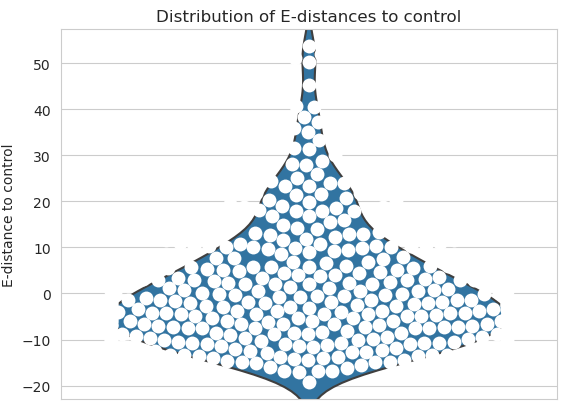

In [16]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['TuD_NC_04'], inner=None)
    sns.swarmplot(data=estats.loc['TuD_NC_04'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




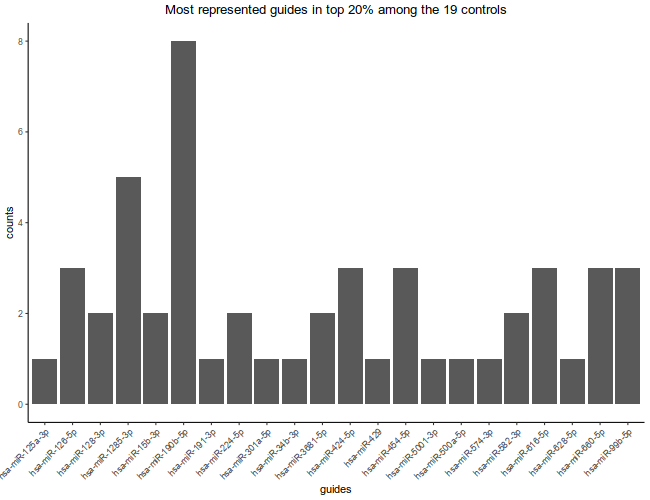

In [17]:
%%R -i estats -w 650 -h 500
library(stringr)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(dplyr)

## draw barplots showing distances of the perturbations to each of the controls
## capture top 20% furthest guides from each of the controls

startsWith(colnames(estats), prefix = 'TuD') -> status
names <- rownames(estats)[status]
tp20_pct = rep(list(matrix(0,5,5)), length(names))
dotplot = rep(list(matrix(0,5,5)), length(names))
for (i in 1:length(names)){
  startsWith(colnames(estats), prefix = 'TuD') -> status
  control_status = 1:length(status)
  control_status[status] <- 'control'
  control_status[!status] <- 'perturbation'
  estats_control1 <- data.frame(comparison_to_control_NC1 = estats[,names[i]], guide = control_status, guide_nm = rownames(estats))
  estats_control1 <- estats_control1[order(estats_control1$guide, decreasing = TRUE),]
  estats_control1$guide <- factor(estats_control1$guide, levels = c('perturbation', 'control'))
  tp20_pct[[i]] <- as.character(estats_control1[order(estats_control1$comparison_to_control_NC1, decreasing = TRUE),"guide_nm"][1:ceiling(0.2*nrow(estats_control1))])
  dotplot[[i]] = ggplot(estats_control1, aes(x = 1, y=comparison_to_control_NC1, fill = guide)) + 
    geom_dotplot(binaxis='y', stackdir='center',
                 stackratio=1.5, dotsize=1.2, binwidth = 0.5) + scale_fill_viridis_d() + 
    geom_text_repel(aes(y = comparison_to_control_NC1, x = 1, label = guide_nm),
                    xlim = c(0, 0.95), 
                    direction = "y") +
    theme_classic() + ylab('E-distance to TuD_NC') + xlab('') + ggtitle(names[i])
}

names(dotplot) <- names

## given that each of the top 20% of guides are different based on
## which control you're comparing to, we take top 20% guides from 5 sampled controls
## and find intersecting guides among the 5.
## we repeat this process 10 times (hopefully drawing different controls each time) 
## and draw a histogram to find most common guides

set.seed(44)
nms_list = replicate(10, Reduce(intersect, sample(tp20_pct, 5, replace = FALSE)))
nms = unlist(nms_list)
df = data.frame(guides = nms)
df = count(df, guides, name = 'counts')

barpl <- ggplot(df, aes(x = guides, y = counts)) + geom_col() + theme_classic() + ggtitle('Most represented guides in top 20% among the 19 controls') +
  theme(axis.text.x = element_text(angle = 45, hjust=1), plot.title = element_text(hjust = 0.5)) 


pdf('/home/ssobti/projects/mir_tud/output_data/edist/miR_perturbs_to_varying_controls.pdf', height = 4, width = 5)
print(barpl)
for (i in 1:length(names)){
  print(dotplot[[i]])
}
dev.off()

barpl

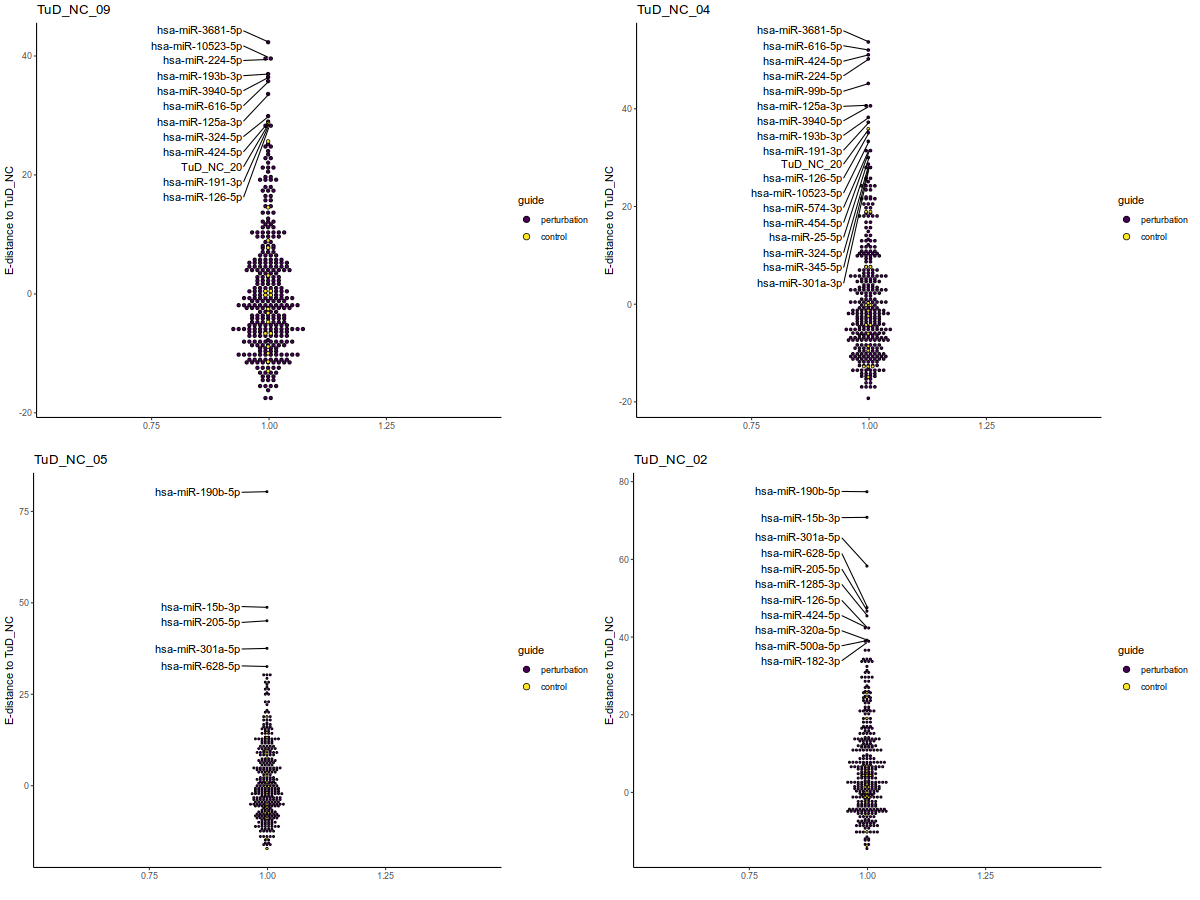

In [18]:
%%R -w 1200 -h 900
## representative controls for barplot above
controls_to_plot <- c('TuD_NC_09', 'TuD_NC_04', 'TuD_NC_05', 'TuD_NC_02')
ggarrange(plotlist = dotplot[controls_to_plot], nrow = 2, ncol = 2)


Heatmap of pariwise E-distances of perturbations to each other

In [19]:
## in this heatmap a lighter color means a perturbation is further away from another perturbation
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100])
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/miR_edist_heatmap_separate_controls.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [20]:
## better color scheme
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100], cmap="vlag", vmin = -10, vmax = 10, cbar_kws={"ticks":[-10, -5,  0, 5,  10]})
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/miR_edist_heatmap_color2_separate_controls.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


# E-testing (p-value calculation)

In [ ]:
## perform e-testing using each control guide (slow ~ 5hrs)
# e-testing -- here's what it's doing based on the paper:
## pvalue is found by combining the control cells and pertubation cells and switching their control/perturbation labels
## randomly 100 times to see how many times one gets a distance larger than when using the true original labels
## p-values are then adjusted using the Holm-Sidak method for multiple comparisons
ctrls = pd.Series(list(set(meta.loc[:,'guide'])))
ctrls = ctrls[ctrls.str.startswith('TuD')].sort_values().reset_index(drop=True)
prep_dict = dict(zip(ctrls, [0 for x in ctrls]))

for x in ctrls:
    prep_dict[x] = etest(adata, obs_key='guide', obsm_key='X_pca', dist='sqeuclidean', control=x, alpha=0.05, runs=100)

In [ ]:
import shelve
filenm = '/home/ssobti/projects/mir_tud/output_data/edist/miR_etest_prep_dict_controls_separate.out'
my_shelf = shelve.open(filenm,'n') # 'n' for new
vec = ['estats', 'prep_dict', 'ctrls']
for key in vec:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
    except pickle.PicklingError:
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

In [37]:
## load saved data
import shelve
filenm = '/home/ssobti/projects/mir_tud/output_data/edist/miR_etest_prep_dict_controls_separate.out'
my_shelf = shelve.open(filenm)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

In [38]:
## pull out pvalues in prep_dict for each control run and put into a new df (pvals_df)
pvals_df = pd.DataFrame()
for x in ctrls:
    try:
        pvals_df.loc[:,x] = prep_dict[x].loc[:, 'pvalue']
    except KeyError:
        print(x + ' was not calculated')

In [39]:
pvals_df

TuD_NC_01  TuD_NC_02  TuD_NC_03  TuD_NC_04  TuD_NC_05  \
TuD_NC_01              0.00       0.96       0.67       0.05       0.33   
TuD_NC_02              0.93       0.00       0.97       0.04       0.79   
TuD_NC_03              0.59       0.98       0.00       0.15       0.93   
TuD_NC_04              0.06       0.05       0.16       0.00       0.05   
TuD_NC_05              0.34       0.78       0.98       0.05       0.00   
...                     ...        ...        ...        ...        ...   
hsa-miR-10399-3p       0.09       0.31       0.65       0.85       0.33   
hsa-miR-10399-5p       0.07       0.13       0.55       0.89       0.14   
hsa-miR-10523-5p       0.11       0.31       0.62       0.09       0.59   
hsa-miR-10526-3p       0.20       0.25       0.70       0.91       0.42   
hsa-miR-10527-5p       0.10       0.33       0.57       0.02       0.93   

                  TuD_NC_06  TuD_NC_07  TuD_NC_08  TuD_NC_09  TuD_NC_10  \
TuD_NC_01              0.07       0.53       0.09       0.00       0.04   
TuD_NC_02              0.23       0.78       0.59       0.00       0.10   
TuD_NC_03              0.56       0.94       0.78       0.14       0.50   
TuD_NC_04              0.73       0.61       0.29       0.43       0.25   
TuD_NC_05              0.50       0.66       0.54       0.08       0.61   
...                     ...        ...        ...        ...        ...   
hsa-miR-10399-3p       0.70       0.75       0.71       0.31       0.48   
hsa-miR-10399-5p       0.72       0.67       0.22       0.26       0.56   
hsa-miR-10523-5p       0.32       0.21       0.23       0.09       0.79   
hsa-miR-10526-3p       0.72       0.98       0.41       0.39       0.45   
hsa-miR-10527-5p       0.59       0.40       0.27       0.04       0.68   

                  TuD_NC_11  TuD_NC_12  TuD_NC_14  TuD_NC_15  TuD_NC_16  \
TuD_NC_01              0.07       0.02       0.07       0.02       0.35   
TuD_NC_02              0.45       0.07       0.34       0.26       0.77   
TuD_NC_03              0.85       0.39       0.65       0.60       0.83   
TuD_NC_04              0.46       0.43       0.56       0.15       0.65   
TuD_NC_05              0.58       0.50       0.26       0.27       0.76   
...                     ...        ...        ...        ...        ...   
hsa-miR-10399-3p       0.94       0.59       0.92       0.62       0.93   
hsa-miR-10399-5p       0.65       0.33       0.80       0.14       0.72   
hsa-miR-10523-5p       0.41       0.28       0.29       0.07       0.34   
hsa-miR-10526-3p       0.80       0.62       0.93       0.33       0.78   
hsa-miR-10527-5p       0.54       0.25       0.28       0.07       0.19   

                  TuD_NC_17  TuD_NC_18  TuD_NC_19  TuD_NC_20  
TuD_NC_01              0.91       0.05       0.00       0.07  
TuD_NC_02              1.00       0.35       0.14       0.25  
TuD_NC_03              1.00       0.71       0.65       0.74  
TuD_NC_04              0.17       0.18       0.37       0.07  
TuD_NC_05              0.94       0.32       0.44       0.86  
...                     ...        ...        ...        ...  
hsa-miR-10399-3p       0.50       0.73       0.64       0.32  
hsa-miR-10399-5p       0.22       0.23       0.77       0.18  
hsa-miR-10523-5p       0.44       0.12       0.77       0.64  
hsa-miR-10526-3p       0.46       0.45       0.77       0.20  
hsa-miR-10527-5p       0.47       0.11       0.36       0.51  

[346 rows x 19 columns]

In [40]:
## convert p-vals across rows (ie the comparison of each guide to the 20 controls) to z-scores
## make all p-vals of 0 equal to 0.001
pvals_df[pvals_df == 0] = 0.001
pvals_df[pvals_df == 1] = 0.999
z_scores_df = pvals_df.copy()
import scipy as sp
import math
for index, row in pvals_df.iterrows():
    z_scores_df.loc[index,:] = sp.stats.norm.ppf(1 - row)

In [41]:
## calculate combined zscores

def combine_zscores(scores):
    return sum(scores)/np.sqrt(len(scores))

zscores_comb = z_scores_df.apply(combine_zscores, axis = 1)

In [42]:
z_scores_df

TuD_NC_01  TuD_NC_02  TuD_NC_03  TuD_NC_04  TuD_NC_05  \
TuD_NC_01          3.090232  -1.750686  -0.439913   1.644854   0.439913   
TuD_NC_02         -1.475791   3.090232  -1.880794   1.750686  -0.806421   
TuD_NC_03         -0.227545  -2.053749   3.090232   1.036433  -1.475791   
TuD_NC_04          1.554774   1.644854   0.994458   3.090232   1.644854   
TuD_NC_05          0.412463  -0.772193  -2.053749   1.644854   3.090232   
...                     ...        ...        ...        ...        ...   
hsa-miR-10399-3p   1.340755   0.495850  -0.385320  -1.036433   0.439913   
hsa-miR-10399-5p   1.475791   1.126391  -0.125661  -1.226528   1.080319   
hsa-miR-10523-5p   1.226528   0.495850  -0.305481   1.340755  -0.227545   
hsa-miR-10526-3p   0.841621   0.674490  -0.524401  -1.340755   0.201893   
hsa-miR-10527-5p   1.281552   0.439913  -0.176374   2.053749  -1.475791   

                  TuD_NC_06  TuD_NC_07  TuD_NC_08  TuD_NC_09  TuD_NC_10  \
TuD_NC_01          1.475791  -0.075270   1.340755   3.090232   1.750686   
TuD_NC_02          0.738847  -0.772193  -0.227545   3.090232   1.281552   
TuD_NC_03         -0.150969  -1.554774  -0.772193   1.080319   0.000000   
TuD_NC_04         -0.612813  -0.279319   0.553385   0.176374   0.674490   
TuD_NC_05          0.000000  -0.412463  -0.100434   1.405072  -0.279319   
...                     ...        ...        ...        ...        ...   
hsa-miR-10399-3p  -0.524401  -0.674490  -0.553385   0.495850   0.050154   
hsa-miR-10399-5p  -0.582842  -0.439913   0.772193   0.643345  -0.150969   
hsa-miR-10523-5p   0.467699   0.806421   0.738847   1.340755  -0.806421   
hsa-miR-10526-3p  -0.582842  -2.053749   0.227545   0.279319   0.125661   
hsa-miR-10527-5p  -0.227545   0.253347   0.612813   1.750686  -0.467699   

                  TuD_NC_11  TuD_NC_12  TuD_NC_14  TuD_NC_15  TuD_NC_16  \
TuD_NC_01          1.475791   2.053749   1.475791   2.053749   0.385320   
TuD_NC_02          0.125661   1.475791   0.412463   0.643345  -0.738847   
TuD_NC_03         -1.036433   0.279319  -0.385320  -0.253347  -0.954165   
TuD_NC_04          0.100434   0.176374  -0.150969   1.036433  -0.385320   
TuD_NC_05         -0.201893   0.000000   0.643345   0.612813  -0.706303   
...                     ...        ...        ...        ...        ...   
hsa-miR-10399-3p  -1.554774  -0.227545  -1.405072  -0.305481  -1.475791   
hsa-miR-10399-5p  -0.385320   0.439913  -0.841621   1.080319  -0.582842   
hsa-miR-10523-5p   0.227545   0.582842   0.553385   1.475791   0.412463   
hsa-miR-10526-3p  -0.841621  -0.305481  -1.475791   0.439913  -0.772193   
hsa-miR-10527-5p  -0.100434   0.674490   0.582842   1.475791   0.877896   

                  TuD_NC_17  TuD_NC_18  TuD_NC_19  TuD_NC_20  
TuD_NC_01         -1.340755   1.644854   3.090232   1.475791  
TuD_NC_02         -3.090232   0.385320   1.080319   0.674490  
TuD_NC_03         -3.090232  -0.553385  -0.385320  -0.643345  
TuD_NC_04          0.954165   0.915365   0.331853   1.475791  
TuD_NC_05         -1.554774   0.467699   0.150969  -1.080319  
...                     ...        ...        ...        ...  
hsa-miR-10399-3p   0.000000  -0.612813  -0.358459   0.467699  
hsa-miR-10399-5p   0.772193   0.738847  -0.738847   0.915365  
hsa-miR-10523-5p   0.150969   1.174987  -0.738847  -0.358459  
hsa-miR-10526-3p   0.100434   0.125661  -0.738847   0.841621  
hsa-miR-10527-5p   0.075270   1.226528   0.358459  -0.025069  

[346 rows x 19 columns]

In [43]:
zscores_comb

TuD_NC_01           5.249288
TuD_NC_02           1.320773
TuD_NC_03          -1.846858
TuD_NC_04           3.187827
TuD_NC_05           0.290440
                      ...   
hsa-miR-10399-3p   -1.336058
hsa-miR-10399-5p    0.910811
hsa-miR-10523-5p    1.963359
hsa-miR-10526-3p   -1.096038
hsa-miR-10527-5p    2.108428
Length: 346, dtype: float64

In [44]:
mean_distances = estats.loc[z_scores_df.index, estats.columns.str.startswith('TuD')].mean(axis = 1)

In [45]:
## convert zscores_comb to pvalues and remove control guides from results
## remove control guides
p_vals_combined = 1 - sp.stats.norm.cdf(zscores_comb)
df_dict = {'guide' : zscores_comb.index, 'edist': mean_distances, 'pvalue_adj' : p_vals_combined}
df = pd.DataFrame(df_dict)
df = df.drop(df[df['guide'].str.startswith('TuD')].index)
df = df.reset_index(drop = True)
df['significant_adj'] = df['pvalue_adj'] < 0.05
df = df.set_index('guide')
df.index.name = None
df

edist  pvalue_adj  significant_adj
hsa-let-7a-2-3p   -1.647327    0.504133            False
hsa-let-7b-3p     12.239667    0.000003             True
hsa-let-7d-3p     -2.824993    0.891813            False
hsa-let-7f-2-3p    0.955874    0.239865            False
hsa-let-7i-3p     -2.209204    0.805165            False
...                     ...         ...              ...
hsa-miR-10399-3p  -3.515306    0.909235            False
hsa-miR-10399-5p   0.979398    0.181197            False
hsa-miR-10523-5p   4.281760    0.024802             True
hsa-miR-10526-3p  -3.156393    0.863469            False
hsa-miR-10527-5p   4.830948    0.017497             True

[327 rows x 3 columns]

In [ ]:
df.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/miR_etest_df_separate_controls.csv')

In [26]:
df = pd.read_csv('/home/ssobti/projects/mir_tud/output_data/edist/miR_etest_df_separate_controls.csv', index_col=0)
df.sort_values('pvalue_adj')
df.sort_values('pvalue_adj').iloc[0:20,:]

edist    pvalue_adj  significant_adj
hsa-miR-15b-3p    34.275593  0.000000e+00             True
hsa-miR-190b-5p   60.501553  0.000000e+00             True
hsa-miR-28-5p     35.157215  0.000000e+00             True
hsa-miR-126-5p    22.873044  9.252599e-13             True
hsa-miR-99b-5p    23.518871  1.652656e-11             True
hsa-miR-429       22.620920  1.474337e-10             True
hsa-miR-769-5p    18.583783  1.496476e-10             True
hsa-miR-424-5p    19.684644  1.861916e-10             True
hsa-miR-130b-5p   21.366887  4.571565e-10             True
hsa-miR-301a-5p   20.336235  3.269520e-09             True
hsa-miR-1303      17.024849  1.437170e-08             True
hsa-miR-9903      13.909415  3.959995e-08             True
hsa-miR-664a-5p   16.016288  5.765819e-08             True
hsa-miR-183-3p    17.167976  7.570595e-08             True
hsa-miR-660-5p    13.798215  1.858698e-07             True
hsa-miR-1307-3p   12.945469  3.680164e-07             True
hsa-miR-26a-1-3p  14.684686  8.305719e-07             True
hsa-let-7b-3p     12.239667  3.261439e-06             True
hsa-miR-3619-5p    9.979455  4.764979e-06             True
hsa-miR-204-5p    11.795390  5.502085e-06             True

In [33]:
df.sort_values('pvalue_adj').iloc[-5:-1,:]

edist  pvalue_adj  significant_adj
hsa-miR-30a-3p  -7.364801    0.999969            False
hsa-miR-3064-5p -8.884393    0.999981            False
hsa-miR-21-3p   -8.613834    0.999990            False
hsa-miR-23b-5p  -9.242727    0.999996            False

### Scatter plot of E-distance from control vs adjusted p-value

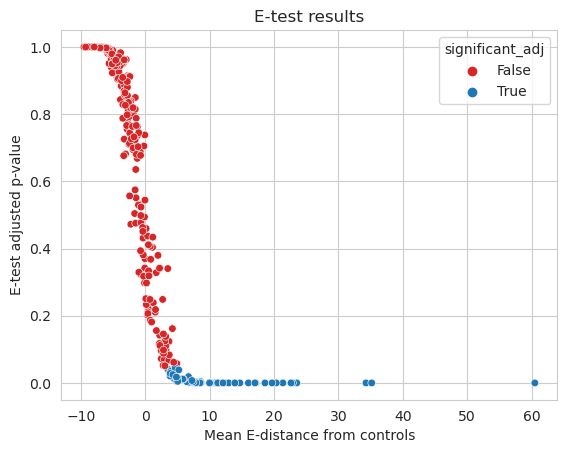

In [27]:
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:blue', False: 'tab:red'}, s=30)
pl.title('E-test results')
pl.xlabel('Mean E-distance from controls')
pl.ylabel('E-test adjusted p-value')
pl.show()

In [28]:
meta2 = adata.obs
meta2

sample           barcode           guide       lor  \
miR_1:ATTTACCGTCATGGCC-1  miR_1  ATTTACCGTCATGGCC       TuD_NC_01  3.597523   
miR_2:AGCGTATCAATGACCT-1  miR_2  AGCGTATCAATGACCT       TuD_NC_01  0.629471   
miR_2:GCCAGGTAGGAGTACC-1  miR_2  GCCAGGTAGGAGTACC       TuD_NC_01  4.196521   
miR_2:CCTCTAGTCCTAGAGT-1  miR_2  CCTCTAGTCCTAGAGT       TuD_NC_01  4.064724   
miR_3:GTCTCACAGCTCTGTA-1  miR_3  GTCTCACAGCTCTGTA       TuD_NC_01  3.976555   
...                         ...               ...             ...       ...   
miR_2:GGTAGAGTCTACGGGC-1  miR_2  GGTAGAGTCTACGGGC  hsa-miR-423-5p  2.902440   
miR_2:CTGTGAACACAGTCCG-1  miR_2  CTGTGAACACAGTCCG  hsa-miR-423-5p  1.770472   
miR_1:ATAGGCTAGTAAGGGA-1  miR_1  ATAGGCTAGTAAGGGA  hsa-miR-423-5p  4.361066   
miR_2:ATTCCATGTGTACAGG-1  miR_2  ATTCCATGTGTACAGG  hsa-miR-423-5p  1.113251   
miR_2:TGATTTCAGCGTCTCG-1  miR_2  TGATTTCAGCGTCTCG  hsa-miR-423-5p  5.381739   

                                 pvalue     adj_pvalue  max_umi  n_umi  \
miR_1:ATTTACCGTCATGGCC-1   1.730526e-45   1.746539e-38     40.0   65.0   
miR_2:AGCGTATCAATGACCT-1   2.036000e-07   1.000000e+00      8.0   34.0   
miR_2:GCCAGGTAGGAGTACC-1   9.101111e-57   9.472211e-50     48.0   78.0   
miR_2:CCTCTAGTCCTAGAGT-1   6.093434e-64   6.341895e-57     57.0  100.0   
miR_3:GTCTCACAGCTCTGTA-1   2.013763e-54   1.612518e-47     46.0   85.0   
...                                 ...            ...      ...    ...   
miR_2:GGTAGAGTCTACGGGC-1   3.718338e-29   3.869954e-22     10.0   14.0   
miR_2:CTGTGAACACAGTCCG-1   2.662270e-15   2.770824e-08      7.0   41.0   
miR_1:ATAGGCTAGTAAGGGA-1  7.813807e-187  7.886111e-180     76.0   95.0   
miR_2:ATTCCATGTGTACAGG-1  1.315885e-263  1.369540e-256    121.0  280.0   
miR_2:TGATTTCAGCGTCTCG-1  2.318224e-129  2.412750e-122     51.0   73.0   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:ATTTACCGTCATGGCC-1  0.163728   4.086762     1.602060   1.812913   
miR_2:AGCGTATCAATGACCT-1  0.085642   0.230021     0.903090   1.531479   
miR_2:GCCAGGTAGGAGTACC-1  0.196474   5.855240     1.681241   1.892095   
miR_2:CCTCTAGTCCTAGAGT-1  0.251889   8.269725     1.755875   2.000000   
miR_3:GTCTCACAGCTCTGTA-1  0.214106   5.401013     1.662758   1.929419   
...                            ...        ...          ...        ...   
miR_2:GGTAGAGTCTACGGGC-1  0.035264   0.261380     1.000000   1.146128   
miR_2:CTGTGAACACAGTCCG-1  0.103275   0.214055     0.845098   1.612784   
miR_1:ATAGGCTAGTAAGGGA-1  0.239295  14.657240     1.880814   1.977724   
miR_2:ATTCCATGTGTACAGG-1  0.705290  51.339694     2.082785   2.447158   
miR_2:TGATTTCAGCGTCTCG-1  0.183879   6.589840     1.707570   1.863323   

                          log_m_umi  n_counts  n_genes_by_counts  \
miR_1:ATTTACCGTCATGGCC-1  -0.785877   31079.0               6713   
miR_2:AGCGTATCAATGACCT-1  -1.067312   42331.0               6985   
miR_2:GCCAGGTAGGAGTACC-1  -0.706696   34775.0               6833   
miR_2:CCTCTAGTCCTAGAGT-1  -0.598791   36595.0               6749   
miR_3:GTCTCACAGCTCTGTA-1  -0.669372   59330.0               8275   
...                             ...       ...                ...   
miR_2:GGTAGAGTCTACGGGC-1  -1.452662   19595.0               4462   
miR_2:CTGTGAACACAGTCCG-1  -0.986007   46037.0               7348   
miR_1:ATAGGCTAGTAAGGGA-1  -0.621067   21010.0               5165   
miR_2:ATTCCATGTGTACAGG-1  -0.151632   56905.0               7554   
miR_2:TGATTTCAGCGTCTCG-1  -0.735468   33269.0               5422   

                          total_counts  total_counts_mt  pct_counts_mt  
miR_1:ATTTACCGTCATGGCC-1       31079.0           2530.0       8.140545  
miR_2:AGCGTATCAATGACCT-1       42331.0           2765.0       6.531856  
miR_2:GCCAGGTAGGAGTACC-1       34775.0           2766.0       7.953990  
miR_2:CCTCTAGTCCTAGAGT-1       36595.0           2665.0       7.282416  
miR_3:GTCTCACAGCTCTGTA-1       59330.0           3099.0       5.223327  
...                                ...              ...

In [29]:
nn = pd.DataFrame(adata.obsm['X_umap'])

In [30]:
nn3 = pd.DataFrame(adata.obsm['X_pca'])

In [59]:
%%R -i meta2
library(stringr)
set.seed(5)
control_idxs = which(str_sub(meta2$guide, start = 1, end = 6) == 'TuD_NC')
control_idxs = sample(control_idxs, 50)

far_guide_of_interest = 'hsa-miR-15b-3p'
far_guide <- rep('other_miR', nrow(meta2))
far_guide[which(meta2$guide == far_guide_of_interest)] <- far_guide_of_interest
far_guide[control_idxs] <- 'control'

close_guide_of_interest = 'hsa-miR-23b-5p'
close_guide <- rep('other_miR', nrow(meta2))
close_guide[which(meta2$guide == close_guide_of_interest)] <- close_guide_of_interest
close_guide[control_idxs] <- 'control'

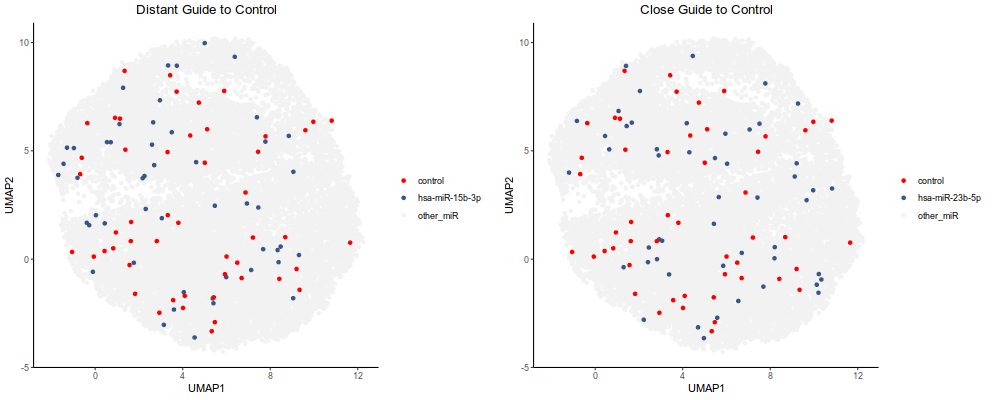

In [60]:
%%R -i nn -h 400 -w 1000

## showing the most distant and least distant pertubation to control
library(dplyr)
library(ggpubr)


nn2 = cbind(nn[,1:2], labs = far_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
a <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn2 = cbind(nn[,1:2], labs = close_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
b <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)

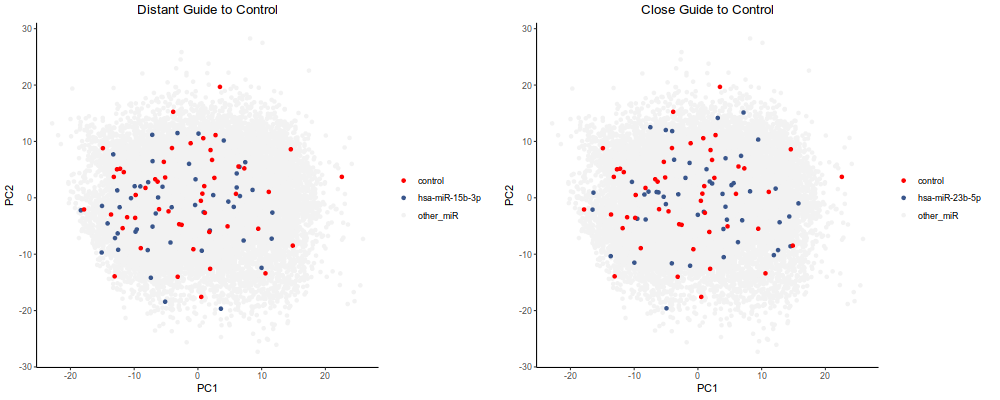

In [61]:
%%R -i nn3 -h 400 -w 1000
## showing the most distant and least distant pertubation to control

nn4 = cbind(nn3[,1:2], labs = far_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
a <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn4 = cbind(nn3[,1:2], labs = close_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
b <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)